In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 📌 Lade den Datensatz
df = pd.read_csv("car_price_dataset.csv")

# 📌 Entferne unrealistische Werte (z. B. Autos mit extrem hohen Laufleistungen oder sehr niedrigen Preisen)
df = df[(df["Price"] > 1000) & (df["Price"] < 500000)]
df = df[(df["Mileage"] > 1000) & (df["Mileage"] < 500000)]

## 📌 Liste der kategorischen Spalten (alle Spalten mit Text)
categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]

# 📌 Wandle jede Spalte in numerische Werte um
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])


# 📌 Überprüfe, ob jetzt alle Spalten numerisch sind
print(df.dtypes)

# 📌 Ersetze Mileage durch `log(Mileage)`
df["Mileage_log"] = np.log1p(df["Mileage"])

# 📌 Berechne das Autoalter
df["Car_Age"] = 2025 - df["Year"]

# 📌 Entferne unnötige Spalten
df = df.drop(columns=["Year", "Mileage"])  # Entferne Original-Mileage

# 📌 Standardisiere numerische Features
scaler = StandardScaler()
numerical_features = ["Engine_Size", "Mileage_log", "Car_Age", "Doors"]
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 📌 Features & Zielvariable definieren
X = df.drop(columns=["Price"])
y = df["Price"]

# 📌 Daten in Trainings- & Testset aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Brand             int64
Model             int64
Year              int64
Engine_Size     float64
Fuel_Type         int64
Transmission      int64
Mileage           int64
Doors             int64
Owner_Count       int64
Price             int64
dtype: object


In [14]:
# 📌 Trainiere einen Random Forest Regressor
rf = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

# 📌 Vorhersagen auf Testset
y_pred = rf.predict(X_test)

# 📌 Fehlerberechnung (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"📊 RMSE des Modells: {rmse:.2f}")


📊 RMSE des Modells: 458.83


🔍 Feature-Wichtigkeiten:
         Feature  Importance
8       Car_Age    0.445327
7   Mileage_log    0.315311
2   Engine_Size    0.137300
4  Transmission    0.047462
3     Fuel_Type    0.039933
1         Model    0.005357
0         Brand    0.003969
6   Owner_Count    0.002832
5         Doors    0.002508


C:\Users\leonk\AppData\Local\Temp\ipykernel_75592\2370883179.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="Blues_r")


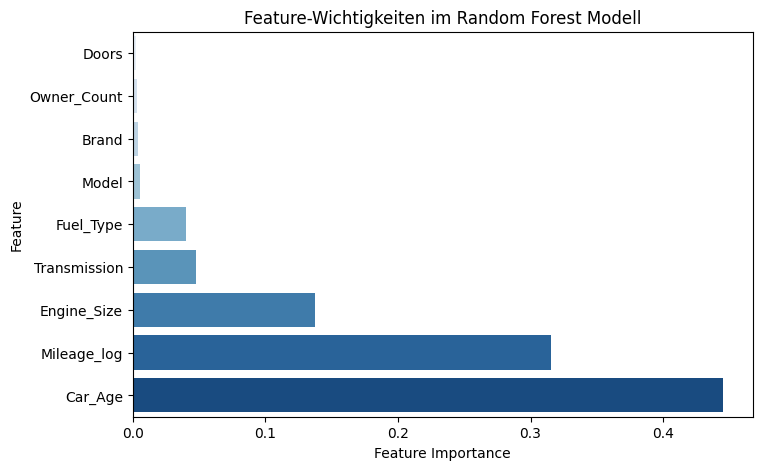

In [15]:
# 📌 Feature-Wichtungen anzeigen
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("🔍 Feature-Wichtigkeiten:\n", feature_importance)

# 📌 Visualisierung der Wichtigkeiten
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="Blues_r")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature-Wichtigkeiten im Random Forest Modell")
plt.gca().invert_yaxis()
plt.show()


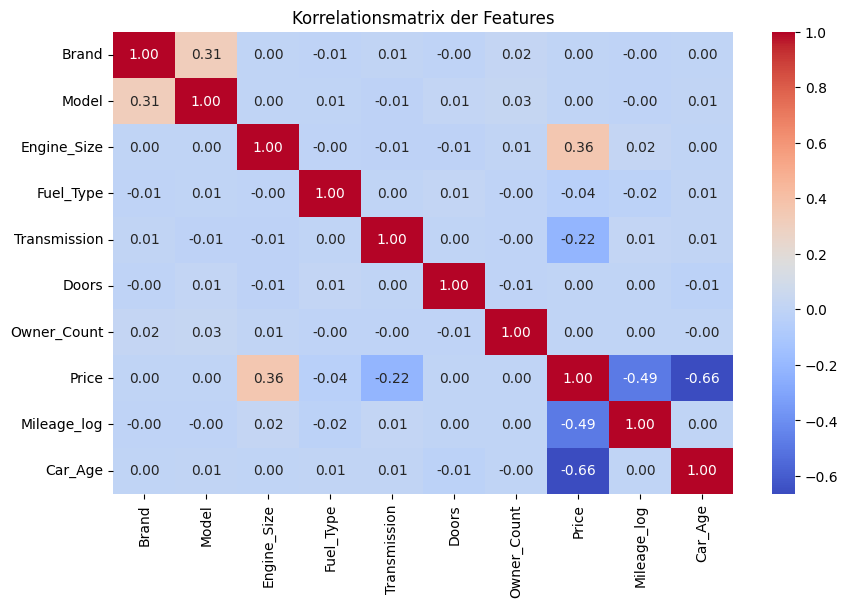

In [16]:
# 📌 Prüfe die Korrelationen der numerischen Features
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelationsmatrix der Features")
plt.show()


In [17]:
import json

# 📌 Feature-Importances & Namen speichern
feature_importances = {
    "feature_names": list(X.columns),
    "feature_importances": list(rf.feature_importances_)
}

# 📌 Skalierungswerte für Frontend speichern
scaling_values = {
    "Engine_Size": {"mean": df["Engine_Size"].mean(), "std": df["Engine_Size"].std()},
    "Mileage_log": {"mean": df["Mileage_log"].mean(), "std": df["Mileage_log"].std()},
    "Car_Age": {"mean": df["Car_Age"].mean(), "std": df["Car_Age"].std()},
    "Doors": {"mean": df["Doors"].mean(), "std": df["Doors"].std()},
    "Price": {"mean": df["Price"].mean(), "std": df["Price"].std()}
}

# 📌 Speichere als JSON
with open("random_forest_model.json", "w") as f:
    json.dump(feature_importances, f)

with open("scaling_info.json", "w") as f:
    json.dump(scaling_values, f)

print("✅ Modell & Skalierungswerte gespeichert!")



✅ Modell & Skalierungswerte gespeichert!


In [18]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("🔍 Beste Hyperparameter:", grid_search.best_params_)



🔍 Beste Hyperparameter: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}


🔍 Beste Hyperparameter: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
📊 RMSE des Modells: 456.69
🔍 Feature-Wichtigkeiten:
         Feature  Importance
8       Car_Age    0.445592
7   Mileage_log    0.315163
2   Engine_Size    0.137058
4  Transmission    0.047598
3     Fuel_Type    0.039941
1         Model    0.005338
0         Brand    0.003965
6   Owner_Count    0.002838
5         Doors    0.002507


C:\Users\leonk\AppData\Local\Temp\ipykernel_75592\3150699337.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="Blues_r")


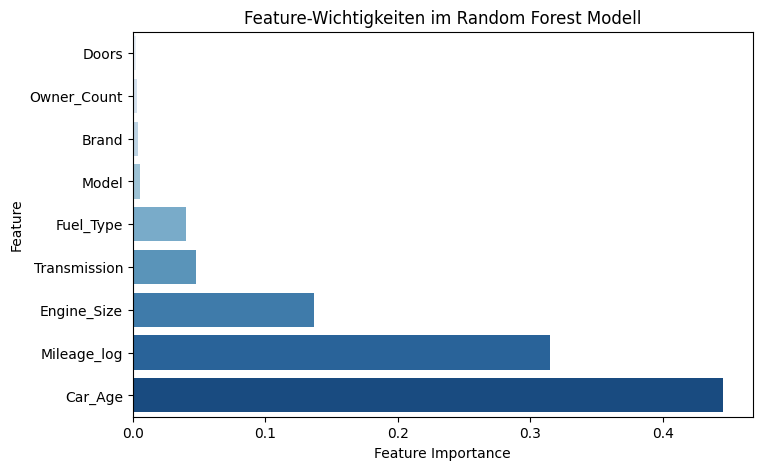

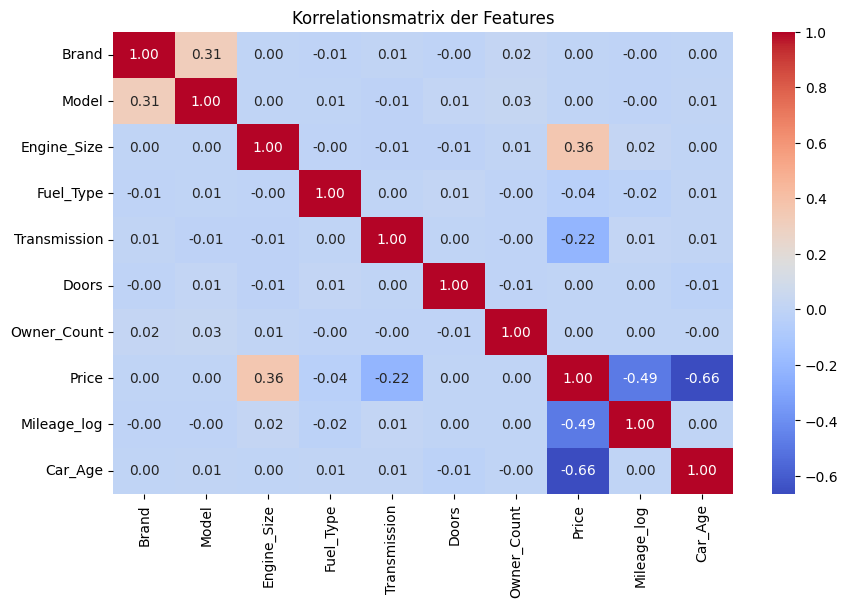

✅ Modell & Skalierungswerte gespeichert!


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# 📌 Lade den Datensatz
df = pd.read_csv("car_price_dataset.csv")

# 📌 Entferne unrealistische Werte
df = df[(df["Price"] > 1000) & (df["Price"] < 500000)]
df = df[(df["Mileage"] > 1000) & (df["Mileage"] < 500000)]

# 📌 Kategorische Werte in numerische umwandeln
categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# 📌 Mileage logarithmisch transformieren
df["Mileage_log"] = np.log1p(df["Mileage"])

# 📌 Autoalter berechnen
df["Car_Age"] = 2025 - df["Year"]

# 📌 Entferne unnötige Spalten
df = df.drop(columns=["Year", "Mileage"])  # Entferne Original-Mileage

# 📌 Standardisiere numerische Features
scaler = StandardScaler()
numerical_features = ["Engine_Size", "Mileage_log", "Car_Age", "Doors"]
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 📌 Features & Zielvariable definieren
X = df.drop(columns=["Price"])
y = df["Price"]

# 📌 Daten in Trainings- & Testset aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 GridSearch für beste Hyperparameter
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("🔍 Beste Hyperparameter:", grid_search.best_params_)

# 📌 Test-Vorhersagen überprüfen
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"📊 RMSE des Modells: {rmse:.2f}")

# 📌 Feature-Wichtungen anzeigen
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("🔍 Feature-Wichtigkeiten:\n", feature_importance)

# 📌 Visualisierung der Feature-Wichtigkeiten
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="Blues_r")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature-Wichtigkeiten im Random Forest Modell")
plt.gca().invert_yaxis()
plt.show()

# 📌 Prüfe die Korrelationen der numerischen Features
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelationsmatrix der Features")
plt.show()

# 📌 Feature-Importances & Namen speichern
feature_importances = {
    "feature_names": list(X.columns),
    "feature_importances": list(best_model.feature_importances_)
}

# 📌 Skalierungswerte für Frontend speichern
scaling_values = {
    "Engine_Size": {"mean": df["Engine_Size"].mean(), "std": df["Engine_Size"].std()},
    "Mileage_log": {"mean": df["Mileage_log"].mean(), "std": df["Mileage_log"].std()},
    "Car_Age": {"mean": df["Car_Age"].mean(), "std": df["Car_Age"].std()},
    "Doors": {"mean": df["Doors"].mean(), "std": df["Doors"].std()},
    "Price": {"mean": df["Price"].mean(), "std": df["Price"].std()}
}

# 📌 Speichere als JSON
with open("random_forest_model.json", "w") as f:
    json.dump(feature_importances, f)

with open("scaling_info.json", "w") as f:
    json.dump(scaling_values, f)

print("✅ Modell & Skalierungswerte gespeichert!")


🔍 Beste Hyperparameter für GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 20, 'n_estimators': 1000}
📊 RMSE für GradientBoosting: 103.52
🔍 Feature-Wichtigkeiten:
                  Feature  Importance
9      Price_per_Mileage    0.738151
8                Car_Age    0.143527
2            Engine_Size    0.049043
7            Mileage_log    0.022766
3              Fuel_Type    0.020512
4           Transmission    0.016398
10  Price_per_EngineSize    0.009582
1                  Model    0.000010
0                  Brand    0.000006
6            Owner_Count    0.000004
5                  Doors    0.000001


C:\Users\leonk\AppData\Local\Temp\ipykernel_75592\2521940907.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="Blues_r")


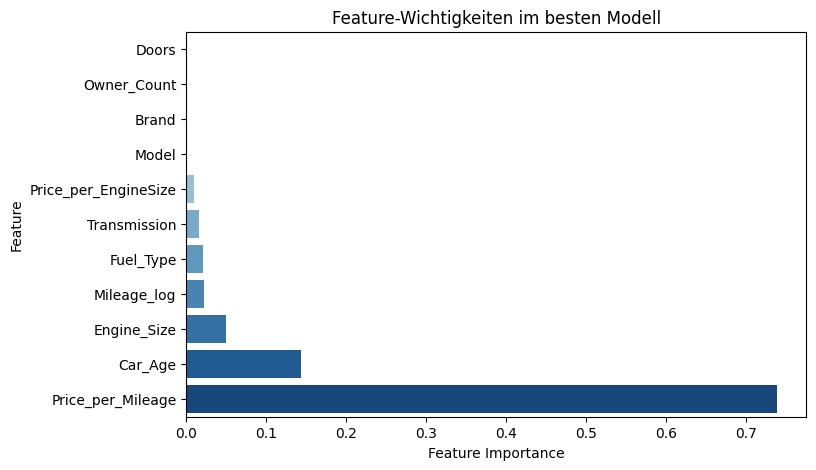

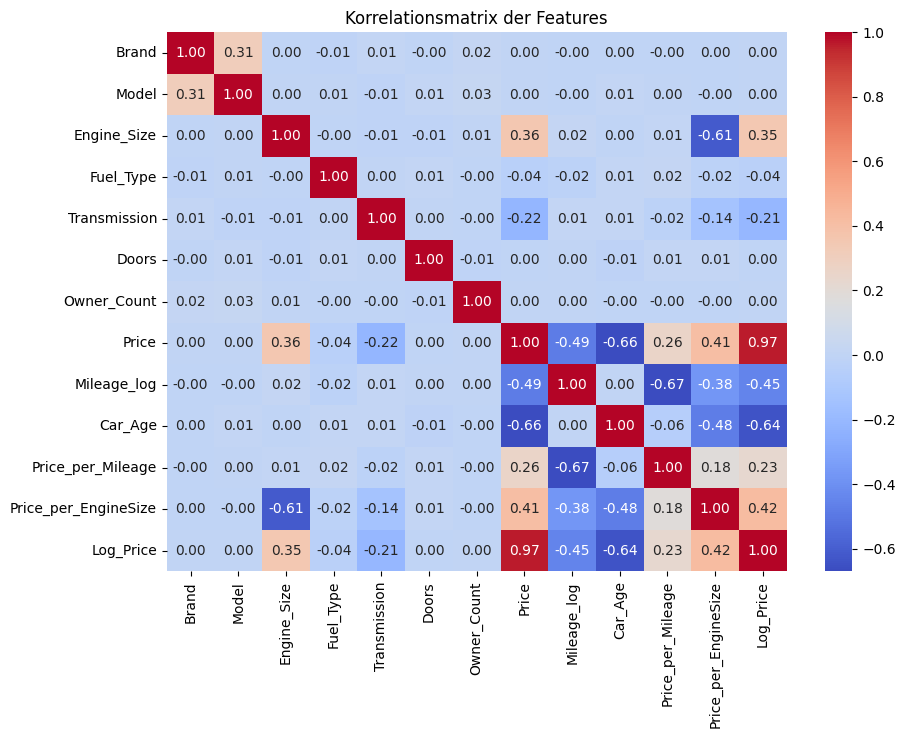

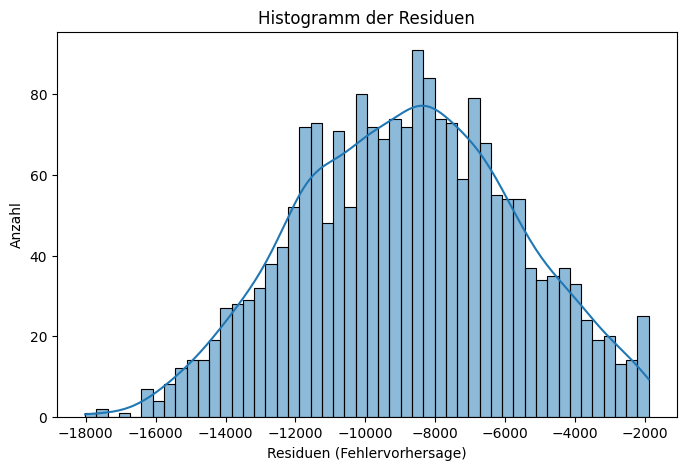

✅ Modell & Skalierungswerte gespeichert!


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# 📌 Lade den Datensatz
df = pd.read_csv("car_price_dataset.csv")

# 📌 Entferne unrealistische Werte
df = df[(df["Price"] > 1000) & (df["Price"] < 500000)]
df = df[(df["Mileage"] > 1000) & (df["Mileage"] < 500000)]

# 📌 Kategorische Werte in numerische umwandeln
categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
for col in categorical_columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# 📌 Mileage logarithmisch transformieren
df["Mileage_log"] = np.log1p(df["Mileage"])

# 📌 Autoalter berechnen
df["Car_Age"] = 2025 - df["Year"]

# 📌 Neue Feature-Engineering-Spalten
df["Price_per_Mileage"] = df["Price"] / df["Mileage"]
df["Price_per_EngineSize"] = df["Price"] / df["Engine_Size"]

# 📌 Entferne unnötige Spalten
df = df.drop(columns=["Year", "Mileage"])  # Entferne Original-Mileage

# 📌 Standardisiere numerische Features
scaler = StandardScaler()
numerical_features = ["Engine_Size", "Mileage_log", "Car_Age", "Doors", "Price_per_Mileage", "Price_per_EngineSize"]
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 📌 Features & Zielvariable definieren
X = df.drop(columns=["Price"])
df["Log_Price"] = np.log1p(df["Price"])
y = df["Log_Price"]

# 📌 Daten in Trainings- & Testset aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 GridSearch für beste Hyperparameter
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'min_samples_split': [10, 20]
}

grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("🔍 Beste Hyperparameter für GradientBoosting:", grid_search.best_params_)

# 📌 Test-Vorhersagen überprüfen
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
print(f"📊 RMSE für GradientBoosting: {rmse:.2f}")

# 📌 Feature-Wichtungen anzeigen
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("🔍 Feature-Wichtigkeiten:\n", feature_importance)

# 📌 Visualisierung der Feature-Wichtigkeiten
plt.figure(figsize=(8, 5))
sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="Blues_r")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature-Wichtigkeiten im besten Modell")
plt.gca().invert_yaxis()
plt.show()

# 📌 Prüfe die Korrelationen der numerischen Features
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korrelationsmatrix der Features")
plt.show()

# 📌 Histogramm der Residuen
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True)
plt.xlabel("Residuen (Fehlervorhersage)")
plt.ylabel("Anzahl")
plt.title("Histogramm der Residuen")
plt.show()

# 📌 Feature-Importances & Namen speichern
feature_importances = {
    "feature_names": list(X.columns),
    "feature_importances": list(best_model.feature_importances_)
}

# 📌 Skalierungswerte für Frontend speichern
scaling_values = {feature: {"mean": df[feature].mean(), "std": df[feature].std()} for feature in numerical_features}

# 📌 Speichere als JSON
with open("gradient_boosting_model.json", "w") as f:
    json.dump(feature_importances, f)

with open("scaling_info.json", "w") as f:
    json.dump(scaling_values, f)

print("✅ Modell & Skalierungswerte gespeichert!")


🔍 Beste Hyperparameter für GradientBoosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 20, 'n_estimators': 1000}
📊 RMSE für GradientBoosting: 43.71


C:\Users\leonk\AppData\Local\Temp\ipykernel_75592\3252547367.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="Blues_r")


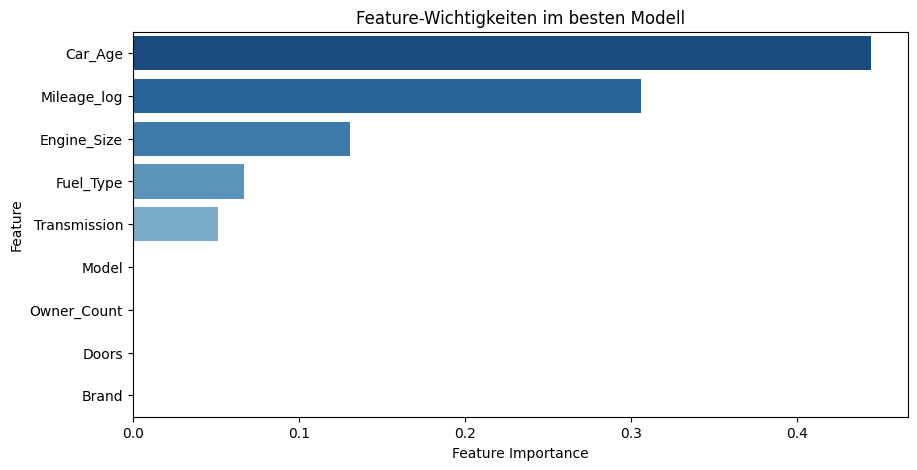

✅ Label-Encoder und StandardScaler wurden gespeichert!
🔍 Modelltest-Ergebnisse auf neuen Daten:
📊 RMSE: 11858.04
📊 MAE: 10539.52
📊 R²-Score: -2.74


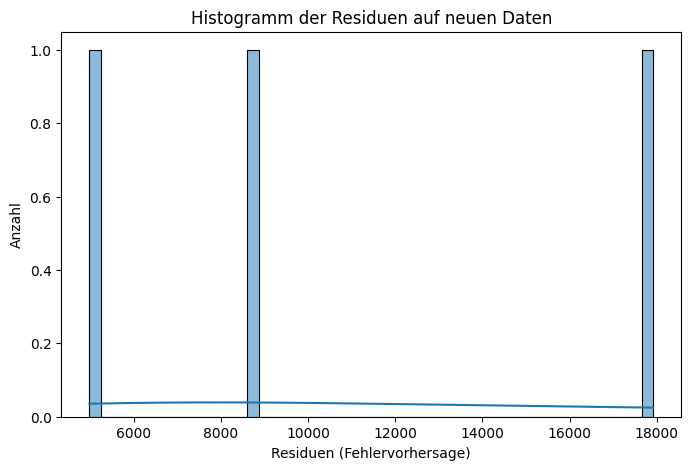

In [61]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 📌 Lade den Datensatz
df = pd.read_csv("car_price_dataset.csv")

# 📌 Entferne unrealistische Werte
df = df[(df["Price"] > 1000) & (df["Price"] < 500000)]
df = df[(df["Mileage"] > 1000) & (df["Mileage"] < 500000)]

# 📌 Kategorische Werte in numerische umwandeln
categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 📌 Mileage logarithmisch transformieren
df["Mileage_log"] = np.log1p(df["Mileage"])

# 📌 Autoalter berechnen
df["Car_Age"] = 2025 - df["Year"]

# 📌 Entferne nicht benötigte Spalten
df = df.drop(columns=["Year", "Mileage"])

# 📌 Box-Cox-Transformation des Preises (falls nötig)
df["Price"], lambda_price = boxcox(df["Price"])

# 📌 Standardisierung
drop_features = ["Price_per_Mileage", "Price_per_EngineSize"]
df = df.drop(columns=[col for col in drop_features if col in df.columns])
scaler = StandardScaler()
numerical_features = ["Engine_Size", "Mileage_log", "Car_Age", "Doors"]
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# 📌 Features & Zielvariable definieren
X = df.drop(columns=["Price"])
y = df["Price"]

# 📌 Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 GridSearch für beste Hyperparameter
param_grid = {
    'n_estimators': [500, 1000],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [10, 20]
}
grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
grid_search.fit(X_train, y_train)

# 📌 Bestes Modell speichern
best_model = grid_search.best_estimator_
print("🔍 Beste Hyperparameter für GradientBoosting:", grid_search.best_params_)

# 📌 Test-Vorhersagen
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"📊 RMSE für GradientBoosting: {rmse:.2f}")

# 📌 Feature-Wichtungen anzeigen
feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importance["Importance"], y=feature_importance["Feature"], palette="Blues_r")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Feature-Wichtigkeiten im besten Modell")
plt.show()

# 📌 Speichere Label-Encoder und Scaler
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)
with open("standard_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
print("✅ Label-Encoder und StandardScaler wurden gespeichert!")

# 📌 Neues Testdatenset vorbereiten
new_data = pd.DataFrame({
    "Brand": ["Toyota", "BMW", "Ford"],
    "Model": ["Corolla", "X5", "Fiesta"],
    "Engine_Size": [1.5, 2.0, 3.0],
    "Fuel_Type": ["Petrol", "Diesel", "Hybrid"],
    "Transmission": ["Manual", "Automatic", "Automatic"],
    "Doors": [4, 2, 5],
    "Owner_Count": [1, 2, 1],
    "Mileage": [50000, 20000, 100000],
    "Year": [2018, 2020, 2015]
})

# ✅ Speichere die echte Preis-Spalte für spätere Fehlerberechnung (synthetische Preise)
true_prices = np.array([15000, 22000, 30000])
true_prices_transformed = (true_prices ** lambda_price - 1) / lambda_price

# 📌 Gleiche Transformationen anwenden
for col in categorical_columns:
    new_data[col] = label_encoders[col].transform(new_data[col])
new_data["Mileage_log"] = np.log1p(new_data["Mileage"])
new_data["Car_Age"] = 2025 - new_data["Year"]
new_data = new_data.drop(columns=["Year", "Mileage"])
new_data[numerical_features] = scaler.transform(new_data[numerical_features])

# 📌 Vorhersagen treffen
y_pred_new = best_model.predict(new_data)
y_pred_new_inverse = (y_pred_new * lambda_price + 1) ** (1 / lambda_price)

# 📌 Modellbewertung
print("🔍 Modelltest-Ergebnisse auf neuen Daten:")
rmse_test = np.sqrt(mean_squared_error(true_prices, y_pred_new_inverse))
mae_test = mean_absolute_error(true_prices, y_pred_new_inverse)
r2_test = r2_score(true_prices, y_pred_new_inverse)
print(f"📊 RMSE: {rmse_test:.2f}")
print(f"📊 MAE: {mae_test:.2f}")
print(f"📊 R²-Score: {r2_test:.2f}")

# 📌 Residuen analysieren
residuals_test = true_prices - y_pred_new_inverse
plt.figure(figsize=(8,5))
sns.histplot(residuals_test, bins=50, kde=True)
plt.xlabel("Residuen (Fehlervorhersage)")
plt.ylabel("Anzahl")
plt.title("Histogramm der Residuen auf neuen Daten")
plt.show()



In [67]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

# 1. Datensatz laden
df = pd.read_csv("car_price_dataset.csv")

# 2. Datenvorverarbeitung
# Entfernen unrealistischer Werte
df = df[(df["Price"] > 1000) & (df["Price"] < 500000)]
df = df[(df["Mileage"] > 1000) & (df["Mileage"] < 500000)]

# Label-Encoding für kategoriale Variablen
categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Feature-Engineering
df["Mileage_log"] = np.sqrt(df["Mileage"])
df["Car_Age"] = 2025 - df["Year"]

# Entfernen nicht benötigter Spalten
df = df.drop(columns=["Year", "Mileage"])

# Standardisierung der numerischen Merkmale
scaler = StandardScaler()
scaler_features = ["Engine_Size", "Mileage_log", "Car_Age", "Doors"]
df[scaler_features] = scaler.fit_transform(df[scaler_features])

# Zielvariable log-transformieren
df["Log_Price"] = np.log1p(df["Price"])

# Features und Zielvariable definieren
X = df.drop(columns=["Price", "Log_Price"])
y = df["Log_Price"]

# 3. Trainings- und Testdaten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Modelltraining
# Ridge Regression mit Alpha=0.1
model = Ridge(alpha=0.1)
model.fit(X_train, y_train)

# 5. Modellbewertung
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)

rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
r2 = r2_score(np.expm1(y_test), y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

# 6. Modell speichern
with open("trained_model.pkl", "wb") as file:
    pickle.dump(model, file)


RMSE: 1410.03
R²: 0.7930


Beste Hyperparameter: {'poly__degree': 3, 'ridge__alpha': 0.1}
RMSE: 230.51
R²: 0.9945


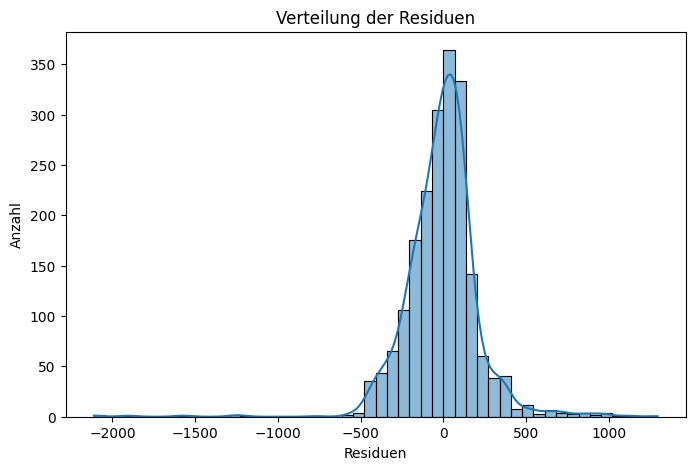

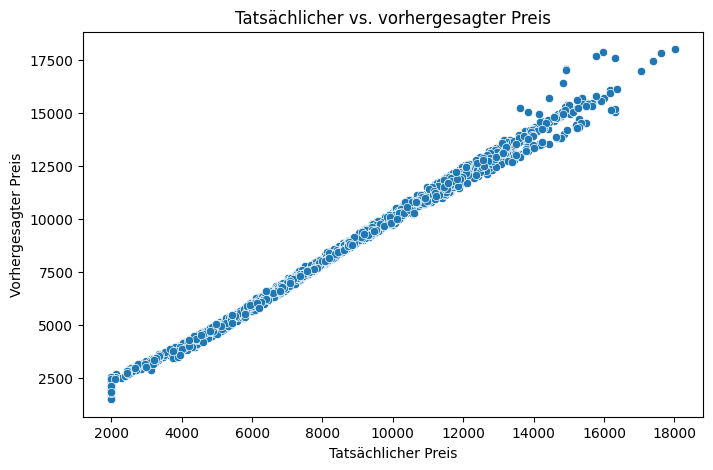

✅ Modellpipeline gespeichert!


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# 📌 Schritt 1: Datenimport und Bereinigung
# Wir laden die Daten und bereinigen sie, um Ausreißer zu minimieren.
df = pd.read_csv("car_price_dataset.csv")

# Unplausible Preise und Kilometerstände entfernen
# Diese Ausreißer könnten sonst die Vorhersagequalität negativ beeinflussen.
df = df[(df["Price"] > 1000) & (df["Price"] < 500000)]
df = df[(df["Mileage"] > 1000) & (df["Mileage"] < 500000)]

# 📌 Schritt 2: Kodierung kategorischer Variablen
# Um mit der Regression arbeiten zu können, kodieren wir kategorische Variablen in numerische Werte.
categorical_columns = ["Brand", "Model", "Fuel_Type", "Transmission"]
label_encoders = {}

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# 📌 Schritt 3: Feature Engineering
# Wir erzeugen zusätzliche Features, um komplexe Zusammenhänge besser abzubilden:
# - Mileage wird mit einer Wurzel transformiert, um eine gleichmäßigere Verteilung zu erhalten.
# - Car_Age berechnet das Fahrzeug-Alter.
df["Mileage_sqrt"] = np.sqrt(df["Mileage"])
df["Car_Age"] = 2025 - df["Year"]

# Unnötige Original-Spalten entfernen, um Redundanzen zu vermeiden.
df.drop(columns=["Year", "Mileage"], inplace=True)

# 📌 Schritt 4: Zielvariable log-transformieren
# Die log-Transformation der Zielvariable hilft, Verzerrungen und Ausreißer zu verringern.
df["Log_Price"] = np.log1p(df["Price"])

# 📌 Schritt 5: Daten in Trainings- & Testset splitten
# Die Daten werden gesplittet, um die Modellperformance auf unbekannten Daten zu testen.
X = df.drop(columns=["Price", "Log_Price"])
y = df["Log_Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 Schritt 6: Modellpipeline (Polynomiale Features + Ridge Regression)
# PolynomialFeatures erfassen nicht-lineare Zusammenhänge. Ridge-Regression reguliert Overfitting.
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# 📌 Schritt 7: Hyperparameter-Optimierung
# GridSearchCV sucht systematisch die beste Kombination aus Polynomgrad und Ridge-Strafterm.
param_grid = {
    "poly__degree": [1, 2, 3],
    "ridge__alpha": [0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="neg_mean_squared_error")
grid_search.fit(X_train, y_train)

# Ausgabe bester Hyperparameter
best_model = grid_search.best_estimator_
print("🔍 Beste Hyperparameter:", grid_search.best_params_)

# 📌 Schritt 8: Modell-Evaluation auf Testdaten
# Vorhersagen machen und Performance evaluieren
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Rücktransformation auf Original-Preis
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred))
r2 = r2_score(np.expm1(y_test), y_pred)

print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 R²: {r2:.4f}")

# 📌 Schritt 9: Visualisierung der Ergebnisse
# Histogramm der Residuen zeigt Verteilung der Vorhersagefehler
plt.figure(figsize=(8, 5))
sns.histplot(np.expm1(y_test) - y_pred, bins=50, kde=True)
plt.xlabel("Residuen (Vorhersagefehler)")
plt.ylabel("Häufigkeit")
plt.title("Verteilung der Residuen")
plt.show()

# Scatterplot zur Visualisierung der Modellperformance
plt.figure(figsize=(8, 5))
sns.scatterplot(x=np.expm1(y_test), y=y_pred)
plt.xlabel("Tatsächlicher Preis")
plt.ylabel("Vorhergesagter Preis")
plt.title("Tatsächliche vs. vorhergesagte Preise")
plt.show()

# 📌 Schritt 10: Modell speichern
# Modell wird gespeichert, um es später einfach einsetzen zu können.
with open("polynomial_ridge_pipeline.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("✅ Modellpipeline gespeichert!")


In [53]:
import pandas as pd
import numpy as np

# Erstelle eine Statistikübersicht für die Trainingsdaten
train_data_summary = X_train.describe().T

# Füge die Zielvariable (Preis) hinzu
price_summary = pd.DataFrame({
    "count": [len(y_train)],
    "mean": [np.expm1(y_train).mean()],
    "std": [np.expm1(y_train).std()],
    "min": [np.expm1(y_train).min()],
    "25%": [np.expm1(y_train).quantile(0.25)],
    "50%": [np.expm1(y_train).median()],
    "75%": [np.expm1(y_train).quantile(0.75)],
    "max": [np.expm1(y_train).max()]
}, index=["Price (€)"])

# Füge die Preis-Statistiken zur Übersicht hinzu
train_data_summary = pd.concat([train_data_summary, price_summary])

# Zeige die Tabelle an
print(train_data_summary)


                       count         mean          std          min  \
Brand                 7976.0     4.454865     2.880825     0.000000   
Model                 7976.0    14.351680     8.669816     0.000000   
Engine_Size           7976.0    -0.001765     0.998847    -1.740876   
Fuel_Type             7976.0     1.480692     1.107910     0.000000   
Transmission          7976.0     0.990471     0.817771     0.000000   
Doors                 7976.0     0.001152     1.001731    -1.349550   
Owner_Count           7976.0     2.987713     1.422911     1.000000   
Mileage_log           7976.0     0.002551     0.999917    -4.916553   
Car_Age               7976.0    -0.001782     0.997986    -1.661058   
Price_per_Mileage     7976.0    -0.003532     0.970516    -0.289625   
Price_per_EngineSize  7976.0     0.002591     0.999154    -1.604261   
Price (€)             7976.0  8851.881269  3112.457446  2000.000000   

                              25%          50%           75%           max  

In [54]:
print("📌 Neue Daten vor der Skalierung:")
print(new_data.describe().T)

print("📌 Standardisierte Werte der neuen Daten:")
new_data_scaled = new_data.copy()
new_data_scaled[scaler_features] = scaler.transform(new_data[scaler_features])
print(new_data_scaled.describe().T)


📌 Neue Daten vor der Skalierung:
                      count       mean        std       min       25%  \
Brand                   3.0   3.000000   4.358899  0.000000  0.500000   
Model                   3.0  13.666667  13.613719  3.000000  6.000000   
Engine_Size             3.0  -0.725777   0.664538 -1.305834 -1.088313   
Fuel_Type               3.0   1.666667   1.527525  0.000000  1.000000   
Transmission            3.0   0.333333   0.577350  0.000000  0.000000   
Doors                   3.0   0.152109   1.376293 -1.349550 -0.448555   
Owner_Count             3.0   1.333333   0.577350  1.000000  1.000000   
Mileage_log             3.0  -0.916677   0.845323 -1.798246 -1.318522   
Car_Age                 3.0  -0.887796   0.364875 -1.226098 -1.081111   
Price_per_Mileage       3.0   0.489601   0.642720  0.118527  0.118527   
Price_per_EngineSize    3.0   4.054048   0.335228  3.860504  3.860504   

                           50%        75%        max  
Brand                 1.000000   4.

In [55]:
# Features entfernen
X_train_reduced = X_train.drop(columns=["Price_per_Mileage", "Price_per_EngineSize"])
X_test_reduced = X_test.drop(columns=["Price_per_Mileage", "Price_per_EngineSize"])

# Modell trainieren
best_model_reduced = GradientBoostingRegressor(n_estimators=500, max_depth=5, min_samples_split=20, learning_rate=0.1, random_state=42)
best_model_reduced.fit(X_train_reduced, y_train)

# Neue Daten vorbereiten
new_data_reduced = new_data.drop(columns=["Price_per_Mileage", "Price_per_EngineSize"])

# Vorhersagen treffen
y_pred_log_reduced = best_model_reduced.predict(new_data_reduced)
y_pred_reduced = np.expm1(y_pred_log_reduced)

# Bewertung
rmse_reduced = np.sqrt(mean_squared_error(true_prices, y_pred_reduced))
print(f"📊 RMSE ohne Price_per_Mileage & Price_per_EngineSize: {rmse_reduced:.2f}")


📊 RMSE ohne Price_per_Mileage & Price_per_EngineSize: 11896.35
